**Student name: Giorgi Guledani**

**Student ID: 20193667**

# Research 1: How to address the Long Tail Problem?

In [1]:
import pandas as pd
import utils
import seaborn as sns
import matplotlib.pyplot as plt

articles = pd.read_parquet(f'{utils.path}/articles.parquet')
customers = pd.read_parquet(f'{utils.path}/customers.parquet')
transactions = pd.read_parquet(f'{utils.path}/transactions_train.parquet')

# Parameters

In [2]:

K_items = 1 # amount of items to replace with Long Tail items
minimal_replacement = True # if True, will replace at most K items until diversity is 100%. If False, will replace K times regardless of diversity.
top_down_replacement = False # If True, will replace starting from the top ranked short head candidate. If False, will start from the bottom.
alpha = 500 # if None, median is used (=threshold in the middle)

# Identifying short head and long tail items

In [3]:

# Determine the threshold, sales above this value will be Short Head, otherwise Long Tail
transactions_count = transactions.groupby(["article_id"])["article_id"].value_counts(dropna=False)
if not "long_tail" in articles.columns:
    articles = articles.merge(transactions.groupby(['article_id'])["article_id"].value_counts(dropna=False), left_on ="article_id", how="left", right_index=True)
    articles["count"].fillna(0, inplace=True)
    articles = articles.rename(columns={"count": "sales_count"})
    threshold = articles["sales_count"].median() if alpha is None else alpha
    print(f"Threshold (alpha): {threshold}")
    articles["long_tail"] = (articles["sales_count"] <= threshold).astype(int)

Threshold (alpha): 500


Partitioning of Long Tail/Short Head items

<Axes: xlabel='long_tail'>

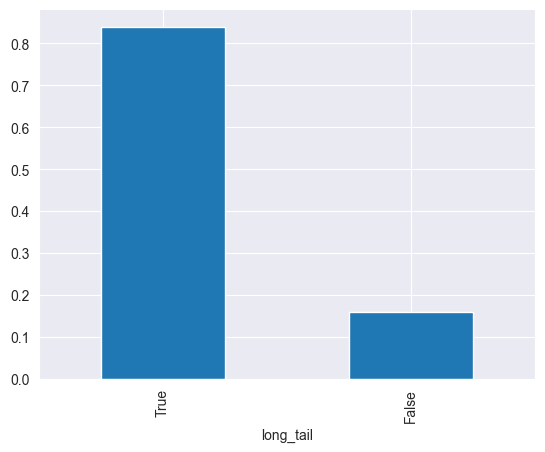

In [4]:
articles["long_tail"].replace({1: "True", 0: "False"}).value_counts(normalize=True).plot(kind='bar')

Items below the threshold get classified as long tail:

In [5]:
sorted_articles = articles[["article_id", "sales_count", "long_tail"]].sort_values(by="sales_count", ascending=False)

sorted_articles.reset_index(drop=True, inplace=True)
sorted_articles

,article_id,sales_count,long_tail
0,706016001,50287.0,0
1,706016002,35043.0,0
2,372860001,31718.0,0
3,610776002,30199.0,0
4,759871002,26329.0,0
...,...,...,...
105537,926010001,0.0,1
105538,896195002,0.0,1
105539,917203001,0.0,1
105540,917203003,0.0,1


From the plot below, we can see that there is a large chunk of Long Tail items because of popularity bias

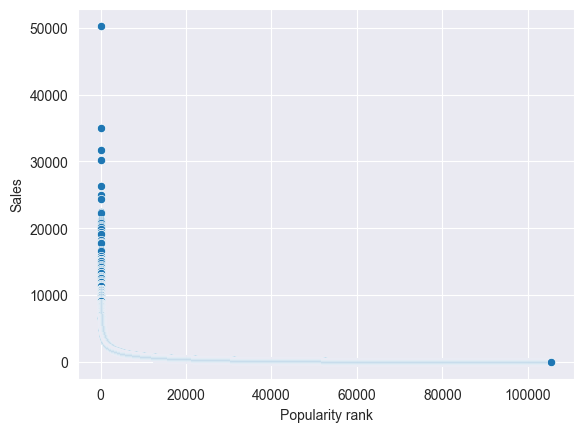

In [6]:
sns.scatterplot(y=sorted_articles["sales_count"], x=sorted_articles.index)
plt.xlabel("Popularity rank")
plt.ylabel("Sales")
plt.show()

The scatterplot shows us that there's a select few in the short head part, while a huge amount is in the long tail part.

# Candidate Generation

In [7]:
test_week = transactions.week.max() + 1
transactions = transactions[transactions.week > transactions.week.max() - 10]

### Last purchase candidates

In [8]:
%%time

c2weeks = transactions.groupby('customer_id')['week'].unique()
transactions.groupby('week')['t_dat'].agg(['min', 'max'])

c2weeks2shifted_weeks = {}

for c_id, weeks in c2weeks.items():
    c2weeks2shifted_weeks[c_id] = {}
    for i in range(weeks.shape[0]-1):
        c2weeks2shifted_weeks[c_id][weeks[i]] = weeks[i+1]
    c2weeks2shifted_weeks[c_id][weeks[-1]] = test_week
    
candidates_last_purchase = transactions.copy()

weeks = []
for i, (c_id, week) in enumerate(zip(transactions['customer_id'], transactions['week'])):
    weeks.append(c2weeks2shifted_weeks[c_id][week])
    
candidates_last_purchase.week=weeks


CPU times: total: 25.2 s
Wall time: 25.2 s


In [9]:
candidates_last_purchase.merge(articles[["article_id", "long_tail"]], on ="article_id", how="left")["long_tail"].value_counts(normalize=True)

long_tail
0    0.648926
1    0.351074
Name: proportion, dtype: float64

Let's first compute the bestseller candidates as usual

In [10]:
sales = transactions \
    .groupby('week')['article_id'].value_counts() \
    .groupby('week').rank(method='dense', ascending=False) \
    .groupby('week').head(12).rename('bestseller_rank').astype('int8')

In [11]:
sales

week  article_id
95    760084003      1
      866731001      2
      600886001      3
      706016001      4
      372860002      5
                    ..
104   915529003      8
      915529005      9
      448509014     10
      762846027     11
      714790020     12
Name: bestseller_rank, Length: 120, dtype: int8

In [12]:
sales_frame = sales.to_frame().reset_index() # DataFrame is easier to use than Series (from Radek), so I'll use this from now on

### Diversity before

I'll measure candidate diversity of these bestseller candidates using Jaccard index

In [13]:
def jaccard_diversity(list1, list2):
    intersection = len(list1.intersection(list2))
    union = len(list1.union(list2))
    jaccard_index = intersection / union
    diversity_index = 1 - jaccard_index
    return diversity_index

def avg_jaccard_diversity(df, weeks_list): # only computes diversity of current with next week (chain)
    jaccard_sum = 0
    pair_count = 0
    
    for i, week1 in enumerate(weeks_list):
        article_ids1 = set(df[df["week"] == week1]["article_id"])
        if week1 == weeks_list.max():
            break
        week2 = week1 + 1
        article_ids2 = set(df[df["week"] == week2]["article_id"])
        diversity_index = jaccard_diversity(article_ids1, article_ids2)
        print(f"{week1}, {week2}: {diversity_index}")
        jaccard_sum += diversity_index
        pair_count += 1
    average_jaccard = jaccard_sum / pair_count
    print(f"Average diversity: {average_jaccard}")


weeks_list = sales_frame["week"].unique()
avg_jaccard_diversity(sales_frame, weeks_list)

95, 96: 0.736842105263158
96, 97: 0.8571428571428572
97, 98: 1.0
98, 99: 1.0
99, 100: 0.8
100, 101: 0.736842105263158
101, 102: 0.5882352941176471
102, 103: 0.8571428571428572
103, 104: 0.5882352941176471
Average diversity: 0.7960489458941472


### Increasing diversity

A lower diversity implies that the same item gets recommended twice in a row per 2 weeks. We will now replace these duplicates by Long Tail items and increase diversity,

Currently, there are fewer Long Tail candidates:

In [14]:
sales_frame.merge(articles[["article_id", "long_tail"]], on ="article_id", how="left")["long_tail"].value_counts()

long_tail
0    119
1      1
Name: count, dtype: int64

In [15]:
def increase_diversity(df, weeks_list, K):
    top_long_tail = articles[articles["long_tail"]==1][["article_id", "sales_count"]].sort_values(by="sales_count", ascending=False).head(200)
    top_long_tail.reset_index(inplace=True)
    long_tail_index = 0 # start from most popular
    for i, week1 in enumerate(weeks_list):
        article_ids1 = set(df[df["week"] == week1]["article_id"])
        if week1 == weeks_list.max():
            break
        week2 = week1 + 1
        items_left = K
        article_ids2 = set(df[df["week"] == week2]["article_id"])
        previous_diversity_index = jaccard_diversity(article_ids1, article_ids2)
        
        current_week = df[df["week"]==week2] if top_down_replacement else df[df["week"]==week2].iloc[::-1]
        for j, item in current_week.iterrows(): # edit items one by one from bottom up until K items edited or diversity maximized
            if items_left == 0:
                break
            
            # Replace current candidate with a long tail item
            old_item = df.at[j, "article_id"]
            new_item = top_long_tail.at[long_tail_index, "article_id"]
            df.at[j, "article_id"] = new_item
            article_ids1 = set(df[df["week"] == week1]["article_id"])
            article_ids2 = set(df[df["week"] == week2]["article_id"])
            diversity_index = jaccard_diversity(article_ids1, article_ids2)
            if minimal_replacement is True:
                if diversity_index > previous_diversity_index: # if new item gives us better diversity than before
                    items_left -= 1
                    long_tail_index += 1
                    previous_diversity_index = diversity_index
    
                else: # change had no effect, set it back to previous item
                    df.at[j, "article_id"] = old_item

                if diversity_index == 1.0:
                    break
            else: # minimal_replacement = False replaces exactly K items with Long Tail items, even when diversity is 100%
                if diversity_index >= previous_diversity_index: # if new item didn't decrease diversity
                    items_left -= 1
                    long_tail_index += 1
                else:
                    df.at[j, "article_id"] = old_item
    return df

sales_frame = increase_diversity(sales_frame, weeks_list, K=K_items)
sales_frame

,week,article_id,bestseller_rank
0,95,760084003,1
1,95,866731001,2
2,95,600886001,3
3,95,706016001,4
4,95,372860002,5
...,...,...,...
115,104,915529003,8
116,104,915529005,9
117,104,448509014,10
118,104,481696002,11


Now we can see an increase in diversity:

In [16]:
avg_jaccard_diversity(sales_frame, weeks_list)

95, 96: 0.8
96, 97: 0.9090909090909091
97, 98: 1.0
98, 99: 1.0
99, 100: 0.8571428571428572
100, 101: 0.8
101, 102: 0.6666666666666667
102, 103: 0.9090909090909091
103, 104: 0.6666666666666667
Average diversity: 0.8454064454064455


Let's now look at the amount of Long Tail candidate items

In [17]:
sales_frame = sales_frame.merge(articles[["article_id", "long_tail"]], on="article_id", how="inner")
sales_frame["long_tail"].value_counts()


long_tail
0    112
1      8
Name: count, dtype: int64

In [18]:
bestsellers_previous_weeks = sales_frame.reset_index()

bestsellers_previous_weeks.week += 1

In [19]:
bestsellers_previous_weeks

,index,week,article_id,bestseller_rank,long_tail
0,0,96,760084003,1,0
1,1,97,760084003,4,0
2,2,96,866731001,2,0
3,3,100,866731001,3,0
4,4,105,866731001,5,0
...,...,...,...,...,...
115,115,105,923758001,4,0
116,116,105,924243002,2,0
117,117,105,915529005,9,0
118,118,105,481696002,11,1


In [20]:
unique_transactions = transactions \
    .groupby(['week', 'customer_id']) \
    .head(1) \
    .drop(columns=['article_id', 'price']) \
    .copy()

In [21]:
unique_transactions

,t_dat,customer_id,sales_channel_id,week
29030503,2020-07-15,272412481300040,1,95
29064059,2020-07-15,1456826891333599,1,95
29067103,2020-07-15,2133687643102426,2,95
29027487,2020-07-15,6010692573790711,1,95
29046403,2020-07-15,6171059100114610,2,95
...,...,...,...,...
31760188,2020-09-22,18435221511488011015,1,104
31782234,2020-09-22,18436859303155335645,1,104
31787251,2020-09-22,18437941771381362708,2,104
31776022,2020-09-22,18438270306572912089,1,104


In [22]:
transactions.drop_duplicates(['week', 'customer_id'])

,t_dat,customer_id,article_id,price,sales_channel_id,week
29030503,2020-07-15,272412481300040,778064028,0.008458,1,95
29064059,2020-07-15,1456826891333599,888294001,0.013542,1,95
29067103,2020-07-15,2133687643102426,843642001,0.042356,2,95
29027487,2020-07-15,6010692573790711,857812010,0.039661,1,95
29046403,2020-07-15,6171059100114610,815447007,0.006763,2,95
...,...,...,...,...,...,...
31760188,2020-09-22,18435221511488011015,573085055,0.033881,1,104
31782234,2020-09-22,18436859303155335645,801447001,0.030492,1,104
31787251,2020-09-22,18437941771381362708,907188001,0.050831,2,104
31776022,2020-09-22,18438270306572912089,751471043,0.033881,1,104


bestseller candidates will be given to users who made purchase in given week

In [23]:
candidates_bestsellers = pd.merge(
    unique_transactions,
    bestsellers_previous_weeks,
    on='week',
)
candidates_bestsellers

,t_dat,customer_id,sales_channel_id,week,index,article_id,bestseller_rank,long_tail
0,2020-07-22,200292573348128,2,96,0,760084003,1,0
1,2020-07-22,200292573348128,2,96,2,866731001,2,0
2,2020-07-22,200292573348128,2,96,5,600886001,3,0
3,2020-07-22,200292573348128,2,96,6,706016001,4,0
4,2020-07-22,200292573348128,2,96,11,372860002,5,0
...,...,...,...,...,...,...,...,...
8141191,2020-09-22,18440902715633436014,1,104,110,739575003,8,1
8141192,2020-09-22,18440902715633436014,1,104,111,762846027,9,0
8141193,2020-09-22,18440902715633436014,1,104,112,809238005,10,0
8141194,2020-09-22,18440902715633436014,1,104,113,673677002,11,0


In [24]:
candidates_bestsellers["long_tail"].value_counts(normalize=True)

long_tail
0    0.934955
1    0.065045
Name: proportion, dtype: float64

In [25]:
test_set_transactions = unique_transactions.drop_duplicates('customer_id').reset_index(drop=True)
test_set_transactions.week = test_week

In [26]:
test_set_transactions

,t_dat,customer_id,sales_channel_id,week
0,2020-07-15,272412481300040,1,105
1,2020-07-15,1456826891333599,1,105
2,2020-07-15,2133687643102426,2,105
3,2020-07-15,6010692573790711,1,105
4,2020-07-15,6171059100114610,2,105
...,...,...,...,...
437360,2020-09-22,18410229429441241008,2,105
437361,2020-09-22,18417769707947924979,2,105
437362,2020-09-22,18418054986721795659,2,105
437363,2020-09-22,18421175435799911749,2,105


In [27]:
bestsellers_previous_weeks

,index,week,article_id,bestseller_rank,long_tail
0,0,96,760084003,1,0
1,1,97,760084003,4,0
2,2,96,866731001,2,0
3,3,100,866731001,3,0
4,4,105,866731001,5,0
...,...,...,...,...,...
115,115,105,923758001,4,0
116,116,105,924243002,2,0
117,117,105,915529005,9,0
118,118,105,481696002,11,1


In [28]:
candidates_bestsellers_test_week = pd.merge(
    test_set_transactions,
    bestsellers_previous_weeks,
    on='week'
)
candidates_bestsellers_test_week

,t_dat,customer_id,sales_channel_id,week,index,article_id,bestseller_rank,long_tail
0,2020-07-15,272412481300040,1,105,4,866731001,5,0
1,2020-07-15,272412481300040,1,105,37,751471001,7,0
2,2020-07-15,272412481300040,1,105,90,915529003,8,0
3,2020-07-15,272412481300040,1,105,99,448509014,10,0
4,2020-07-15,272412481300040,1,105,103,909370001,6,0
...,...,...,...,...,...,...,...,...
5248375,2020-09-22,18438270306572912089,1,105,115,923758001,4,0
5248376,2020-09-22,18438270306572912089,1,105,116,924243002,2,0
5248377,2020-09-22,18438270306572912089,1,105,117,915529005,9,0
5248378,2020-09-22,18438270306572912089,1,105,118,481696002,11,1


Bestsellers from test week get added to bestseller candidates of training weeks

In [29]:
candidates_bestsellers_test_week["long_tail"].value_counts(normalize=True)


long_tail
0    0.916667
1    0.083333
Name: proportion, dtype: float64

In [30]:
candidates_bestsellers = pd.concat([candidates_bestsellers, candidates_bestsellers_test_week])
candidates_bestsellers.drop(columns='bestseller_rank', inplace=True)

In [31]:
candidates_bestsellers

,t_dat,customer_id,sales_channel_id,week,index,article_id,long_tail
0,2020-07-22,200292573348128,2,96,0,760084003,0
1,2020-07-22,200292573348128,2,96,2,866731001,0
2,2020-07-22,200292573348128,2,96,5,600886001,0
3,2020-07-22,200292573348128,2,96,6,706016001,0
4,2020-07-22,200292573348128,2,96,11,372860002,0
...,...,...,...,...,...,...,...
5248375,2020-09-22,18438270306572912089,1,105,115,923758001,0
5248376,2020-09-22,18438270306572912089,1,105,116,924243002,0
5248377,2020-09-22,18438270306572912089,1,105,117,915529005,0
5248378,2020-09-22,18438270306572912089,1,105,118,481696002,1


# Combining transactions and candidates / negative examples


In [32]:
transactions['purchased'] = 1


Set around 30% of long tail candidates to purchased, since only replacing candidates is not effective:

In [33]:
if K_items > 0:
    rows_to_update = int(len(candidates_bestsellers[candidates_bestsellers['long_tail'] == 1]) * 0.3)
    
    # select long tail item candidates, and set purchased to True for some
    selected_rows = candidates_bestsellers[candidates_bestsellers['long_tail'] == 1]
    selected_indices = selected_rows.index
    candidates_bestsellers.loc[selected_indices[:rows_to_update], "purchased"] = 1
    candidates_bestsellers[candidates_bestsellers['long_tail'] == 1]["purchased"].value_counts()


In [34]:
data = pd.concat([transactions, candidates_last_purchase, candidates_bestsellers.drop(columns=["long_tail", "index"])])
data.purchased.fillna(0, inplace=True)
data = data.merge(articles[["article_id", "long_tail"]], on=["article_id"], how="left").reset_index()


In [35]:
data

,index,t_dat,customer_id,article_id,price,sales_channel_id,week,purchased,long_tail
0,0,2020-07-15,272412481300040,778064028,0.008458,1,95,1.0,0
1,1,2020-07-15,272412481300040,816592008,0.016932,1,95,1.0,0
2,2,2020-07-15,272412481300040,621381021,0.033881,1,95,1.0,0
3,3,2020-07-15,272412481300040,817477003,0.025407,1,95,1.0,0
4,4,2020-07-15,272412481300040,899088002,0.025407,1,95,1.0,1
...,...,...,...,...,...,...,...,...,...
18915315,18915315,2020-09-22,18438270306572912089,923758001,NaN,1,105,0.0,0
18915316,18915316,2020-09-22,18438270306572912089,924243002,NaN,1,105,1.0,0
18915317,18915317,2020-09-22,18438270306572912089,915529005,NaN,1,105,0.0,0
18915318,18915318,2020-09-22,18438270306572912089,481696002,NaN,1,105,0.0,1


In [36]:
data.drop_duplicates(['customer_id', 'article_id', 'week'], inplace=True)

Amount of Long Tail items fed to model

In [37]:
data["long_tail"].value_counts(normalize=True)


long_tail
0    0.851548
1    0.148452
Name: proportion, dtype: float64

### Add bestseller information


In [38]:
data = pd.merge(
    data,
    bestsellers_previous_weeks[['week', 'article_id', 'bestseller_rank']],
    on=['week', 'article_id'],
    how='left'
)

In [39]:
bestsellers_previous_weeks

,index,week,article_id,bestseller_rank,long_tail
0,0,96,760084003,1,0
1,1,97,760084003,4,0
2,2,96,866731001,2,0
3,3,100,866731001,3,0
4,4,105,866731001,5,0
...,...,...,...,...,...
115,115,105,923758001,4,0
116,116,105,924243002,2,0
117,117,105,915529005,9,0
118,118,105,481696002,11,1


In [40]:
data = data[data.week != data.week.min()]
data.bestseller_rank.fillna(999, inplace=True)

In [41]:
data

,index,t_dat,customer_id,article_id,price,sales_channel_id,week,purchased,long_tail,bestseller_rank
261987,289528,2020-07-22,200292573348128,880777001,0.025407,2,96,1.0,1,999.0
261988,289529,2020-07-22,200292573348128,784332002,0.025407,2,96,1.0,1,999.0
261989,289530,2020-07-22,200292573348128,827968001,0.016932,2,96,1.0,0,10.0
261990,289531,2020-07-22,200292573348128,599580086,0.011847,2,96,1.0,0,999.0
261991,289532,2020-07-22,248294615847351,720504008,0.031458,1,96,1.0,0,999.0
...,...,...,...,...,...,...,...,...,...,...
18257384,18915315,2020-09-22,18438270306572912089,923758001,NaN,1,105,0.0,0,4.0
18257385,18915316,2020-09-22,18438270306572912089,924243002,NaN,1,105,1.0,0,2.0
18257386,18915317,2020-09-22,18438270306572912089,915529005,NaN,1,105,0.0,0,9.0
18257387,18915318,2020-09-22,18438270306572912089,481696002,NaN,1,105,0.0,1,11.0


In [42]:
data = pd.merge(data, articles, on='article_id', how='left')
data = pd.merge(data, customers, on='customer_id', how='left')

In [43]:
data.sort_values(['week', 'customer_id'], inplace=True)
data.reset_index(drop=True, inplace=True)

In [44]:
data = data.merge(articles[["article_id", "long_tail"]], on=["article_id"], how="left")

In [45]:
train = data[data.week != test_week]
test = data[data.week==test_week].drop_duplicates(['customer_id', 'article_id', 'sales_channel_id']).copy()

In [46]:
train_baskets = train.groupby(['week', 'customer_id'])['article_id'].count().values

In [47]:
columns_to_use = ['article_id', 'product_type_no', 'graphical_appearance_no', 'colour_group_code', 'perceived_colour_value_id',
'perceived_colour_master_id', 'department_no', 'index_code',
'index_group_no', 'section_no', 'garment_group_no', 'FN', 'Active',
'club_member_status', 'fashion_news_frequency', 'age', 'postal_code', 'bestseller_rank']

In [48]:
%%time

train_X = train[columns_to_use]
train_y = train['purchased']

test_X = test[columns_to_use]

CPU times: total: 266 ms
Wall time: 242 ms


In [49]:
# Model training

In [50]:
from lightgbm.sklearn import LGBMRanker

In [51]:
ranker = LGBMRanker(
    objective="lambdarank",
    metric="ndcg",
    boosting_type="dart",
    n_estimators=1,
    importance_type='gain',
    verbose=10
)

In [52]:
%%time

ranker = ranker.fit(
    train_X,
    train_y,
    group=train_baskets,
)

[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.844942
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.152692
[LightGBM] [Debug] init for col-wise cost 0.114958 seconds, init for row-wise cost 0.282704 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.206415 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 1147
[LightGBM] [Info] Number of data points in the train set: 11384345, number of used features: 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
CPU times: total: 21.1 s
Wall time: 7.3 s


In [53]:
for i in ranker.feature_importances_.argsort()[::-1]:
    print(columns_to_use[i], ranker.feature_importances_[i]/ranker.feature_importances_.sum())

bestseller_rank 0.9473252584344444
article_id 0.025770583334048622
colour_group_code 0.016423283840115627
section_no 0.006834565371580109
garment_group_no 0.002375489259168166
department_no 0.0007787629428852392
age 0.0001945998959246076
product_type_no 0.00013847308552603654
postal_code 8.200706696302856e-05
club_member_status 7.697676934414913e-05
fashion_news_frequency 0.0
Active 0.0
FN 0.0
index_code 0.0
perceived_colour_master_id 0.0
perceived_colour_value_id 0.0
graphical_appearance_no 0.0
index_group_no 0.0


# Calculate predictions

In [54]:
%time

test['preds'] = ranker.predict(test_X)

c_id2predicted_article_ids = test \
    .sort_values(['customer_id', 'preds'], ascending=False) \
    .groupby('customer_id')['article_id'].apply(list).to_dict()

bestsellers_last_week = \
    bestsellers_previous_weeks[bestsellers_previous_weeks.week == bestsellers_previous_weeks.week.max()]['article_id'].tolist()

CPU times: total: 0 ns
Wall time: 0 ns


# Create submission

In [55]:
sub = pd.read_csv(utils.path + "sample_submission.csv")

In [56]:
%%time
preds = []
for c_id in utils.customer_hex_id_to_int(sub.customer_id):
    pred = c_id2predicted_article_ids.get(c_id, [])
    pred = pred + bestsellers_last_week
    preds.append(pred[:12])

CPU times: total: 2.92 s
Wall time: 2.92 s


In [57]:
preds = [' '.join(['0' + str(p) for p in ps]) for ps in preds]
sub.prediction = preds

In [58]:
sub_name = "research1_K" + str(K_items)
sub_name += "_a" 
sub_name+= "_median" if alpha is None else str(alpha)
sub_name += "_minimal" if minimal_replacement is True else ""
sub_name += "_topDown" if top_down_replacement is True else "_bottomUp"
sub_name +=".csv.gz"

sub.to_csv(f"{sub_name}", index=False)

# Evaluation

In [59]:
from evaluation import eval_sub, diversity
from create_validation import create_validation
submission = pd.read_csv(sub_name)
print(sub_name)

research1_K1_a500_minimal_bottomUp.csv.gz


In [60]:
create_validation(sub_name)

### MAP@12 score

In [61]:

MAP12_score = eval_sub(sub_name, "map", k=12)
print(f"k={K_items}: {MAP12_score}")

k=1: 0.046641443084854343


### Recall score

In [62]:
recall_score = eval_sub(sub_name, "recall", k=12)
print(recall_score)
print(f"k={K_items}: {recall_score}")

0.04714762048433096
k=1: 0.04714762048433096


### Long Tail item rate

In [63]:
# flatten the list of lists into a single list
flattened_predictions = [int(item) for l in sub.prediction.str.split(" ") for item in l]
flattened_predictions = pd.DataFrame(flattened_predictions, columns=["article_id"])

In [64]:
flattened_predictions = flattened_predictions.merge(articles[["article_id", "long_tail"]], on=["article_id"], how="left")

In [65]:
flattened_predictions["long_tail"].value_counts(normalize=True)

long_tail
0    0.894843
1    0.105157
Name: proportion, dtype: float64

### Diversity

In [66]:
import numpy as np

probabilities = sub.value_counts(normalize=True) # probability distribution

entropy_value = -np.sum(probabilities * np.log2(probabilities))
print(f"k={K_items}: {entropy_value}")


k=1: 20.38782802014161


k=3: 20.38782802014161

In [67]:
diversity_score = diversity(sub_name)
print(f"k={K_items}: {diversity_score}")

k=1: 0.31671044601295467
